# Lab - 3 New York Stock Exchange stock price prediction using LSTM

Use S&P 500 companies historical prices to predict future prices

![alt text](https://farm4.staticflickr.com/3835/14313202637_0cc6ec8649_z_d.jpg)

Reference:https://www.kaggle.com/dgawlik/nyse/home

This dataset is a playground for fundamental and technical analysis. It is said that 30% of traffic on stocks is already generated by machines, can trading be fully automated? If not, there is still a lot to learn from historical data.

Most of data spans from 2010 to the end 2016, for companies new on stock market date range is shorter. There have been approx. 140 stock splits in that time

In [1]:
!wget https://raw.githubusercontent.com/davidjohnnn/econ/master/prices-split-adjusted.csv

--2019-06-16 08:12:54--  https://raw.githubusercontent.com/davidjohnnn/econ/master/prices-split-adjusted.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52701226 (50M) [text/plain]
Saving to: ‘prices-split-adjusted.csv’

prices-split-adjust 100%[===================>]  50.26M   176MB/s    in 0.3s    

2019-06-16 08:12:55 (176 MB/s) - ‘prices-split-adjusted.csv’ saved [52701226/52701226]



In [2]:
!ls

prices-split-adjusted.csv  sample_data


# Setup
import libraries needed for this application

In [0]:
datapath = 'prices-split-adjusted.csv' #or locate in google drive


In [4]:
#import sys
import numpy as np
import pandas as pd
import math
import itertools
from sklearn import preprocessing
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
import keras
import matplotlib.pyplot as plt2

Using TensorFlow backend.


# Read data

![alt text](https://cdn.pixabay.com/photo/2017/09/01/05/49/reading-2703163_1280.jpg)

#### Let's read the CSV file and find out what does it look like?

The first 5 rows of this dataset contains the value of WLTM  during 5 Jan 2016 - 11 Jan 2016.  It contains stock prices of other companies in NYSE as well.

WLTW - Willis Towers Watson is a global multinational risk management, insurance brokerage and advisory company. The firm has roots dating to 1828 and is the third largest insurance broker in the world.  


![alt text](https://pbs.twimg.com/profile_images/1017751865432387584/aionGfv8_400x400.jpg)

In [5]:
# datapath ="/content/stock/prices-split-adjusted.csv"
df = pd.read_csv(datapath, index_col = 0)
df["mv close"] = df.close
df.drop(['volume','close'], 1, inplace=True)
df.head()

,symbol,open,low,high,mv close
date,,,,,
2016-01-05,WLTW,123.430000,122.309998,126.250000,125.839996
2016-01-06,WLTW,125.239998,119.940002,125.540001,119.980003
2016-01-07,WLTW,116.379997,114.930000,119.739998,114.949997
2016-01-08,WLTW,115.480003,113.500000,117.440002,116.620003
2016-01-11,WLTW,117.010002,114.089996,117.330002,114.970001


### Statistical Summary of this dataset

*   count = number of rows in the dataset
*   mean  = average opening/low/high/closing  price
*   std = standard deviation
*   min = min. opening/low/high/closing  price
*   price at 25%/50%/75% percentile
*   max = max. opening/low/high/closing  price



In [6]:
df.describe()

,open,low,high,mv close
count,851264.000000,851264.000000,851264.000000,851264.000000
mean,64.993618,64.336541,65.639748,65.011913
std,75.203893,74.459518,75.906861,75.201216
min,1.660000,1.500000,1.810000,1.590000
25%,31.270000,30.940001,31.620001,31.292776
50%,48.459999,47.970001,48.959999,48.480000
75%,75.120003,74.400002,75.849998,75.139999
max,1584.439941,1549.939941,1600.930054,1578.130005


There are over 500 companies in this dataset including  Google, IBM, CBS Corporation, etc.

In [0]:
#Symbol dimension
symbols = list(set(df.symbol))
print("Here are the list of companies in NYSE")
print(sorted(symbols))
print("There are " + str(len(symbols)) + " companies in NYSE" )

Here are the list of companies in NYSE
['A', 'AAL', 'AAP', 'AAPL', 'ABBV', 'ABC', 'ABT', 'ACN', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADS', 'ADSK', 'AEE', 'AEP', 'AES', 'AET', 'AFL', 'AGN', 'AIG', 'AIV', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALK', 'ALL', 'ALLE', 'ALXN', 'AMAT', 'AME', 'AMG', 'AMGN', 'AMP', 'AMT', 'AMZN', 'AN', 'ANTM', 'AON', 'APA', 'APC', 'APD', 'APH', 'ARNC', 'ATVI', 'AVB', 'AVGO', 'AVY', 'AWK', 'AXP', 'AYI', 'AZO', 'BA', 'BAC', 'BAX', 'BBBY', 'BBT', 'BBY', 'BCR', 'BDX', 'BEN', 'BHI', 'BIIB', 'BK', 'BLK', 'BLL', 'BMY', 'BSX', 'BWA', 'BXP', 'C', 'CA', 'CAG', 'CAH', 'CAT', 'CB', 'CBG', 'CBS', 'CCI', 'CCL', 'CELG', 'CERN', 'CF', 'CFG', 'CHD', 'CHK', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CLX', 'CMA', 'CMCSA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COG', 'COH', 'COL', 'COO', 'COP', 'COST', 'COTY', 'CPB', 'CRM', 'CSCO', 'CSRA', 'CSX', 'CTAS', 'CTL', 'CTSH', 'CTXS', 'CVS', 'CVX', 'CXO', 'D', 'DAL', 'DD', 'DE', 'DFS', 'DG', 'DGX', 'DHI', 'DHR', 'DIS', 'DISCA', 'DISCK', 'DLPH', 'DLR

# Let's predict Google's stock price!

![alt text](https://upload.wikimedia.org/wikipedia/commons/4/4a/Logo_2013_Google.png)
* you can also replace "GOOG" with any company of your choice!

In [0]:
#Focus only 1 stock :GOOG
SYM = 'GOOG'
df = df[df.symbol == SYM]
df.drop(['symbol'],1,inplace=True)
df.head()

,open,low,high,mv close
date,,,,
2010-01-04,312.304948,310.955001,313.580158,312.205308
2010-01-05,312.419511,309.610028,312.748278,310.830459
2010-01-06,311.761979,302.048370,311.761979,302.994813
2010-01-07,303.562685,295.218951,303.861575,295.941242
2010-01-08,294.895159,293.455551,300.499172,299.886470


In [0]:
#Statistical Summary
df.describe()

,open,low,high,mv close
count,1762.000000,1762.000000,1762.000000,1762.000000
mean,459.806530,455.659218,463.484281,459.617409
std,174.026396,172.601608,175.232816,173.946191
min,218.336998,216.005726,220.314587,217.221182
25%,298.255074,295.896412,300.824200,298.389573
50%,436.554429,434.103619,438.701390,436.711351
75%,578.422067,572.884750,581.870130,577.497020
max,816.679993,805.140015,816.679993,813.109985


In [0]:
#Date data dimension
import datetime 

print(df.index.min())
print(df.index.max())
delta = datetime.datetime.strptime(df.index.max(),'%Y-%m-%d')- datetime.datetime.strptime(df.index.min(),'%Y-%m-%d')

2010-01-04
2016-12-30


# Normalize data
Normalization is a common process in machine learning. We do it to make sure that all features are using a common scale. 

In [0]:
def normalize_data(df): # nomalize stock data
    min_max_scaler = preprocessing.MinMaxScaler() #min max scaler
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
#    df['volume'] = min_max_scaler.fit_transform(df.volume.values.reshape(-1,1)) # already remove volume data
    df['mv close'] = min_max_scaler.fit_transform(df['mv close'].values.reshape(-1,1))
    return df
df = normalize_data(df)
df.head(10)

,open,low,high,mv close
date,,,,
2010-01-04,0.157047,0.161167,0.156390,0.159399
2010-01-05,0.157238,0.158884,0.154995,0.157092
2010-01-06,0.156140,0.146049,0.153341,0.143942
2010-01-07,0.142436,0.134457,0.140094,0.132105
2010-01-08,0.127950,0.131464,0.134455,0.138726
2010-01-11,0.138324,0.135632,0.135466,0.137965
2010-01-12,0.132654,0.130525,0.130204,0.129079
2010-01-13,0.115038,0.118603,0.122035,0.126245
2010-01-14,0.121207,0.126137,0.126896,0.128552


# Generate Data for LSTM
![alt text](https://drive.google.com/uc?id=1SOT-t7z2qbfhzJnGmWMhJpz8JlB5V1kn)

Predict the stock price based on the data from the previous 5 days

In [0]:
def load_data(stock, seq_len):   
    n_features = len(stock.columns) #count columns of stock df 4features open/low/high/close
    data = stock.as_matrix()  #change to matrix numpy array
    sequence_length = seq_len + 1 #5+1
    result = []
    
    for index in range(len(data) - sequence_length): #1762 data but exclude sequence len , 0 to 1762-6 => 1756
        result.append(data[index: index + sequence_length]) # construct table with 1756 2d arrays, each with [6,nfeature] (1756,6,4)
    
    result = np.array(result)
    row = round(0.9 * result.shape[0]) # 90% of 1756 data
    train = result[:int(row), :] # select first 90% as train data = 1580 data

    x_train = train[:, :-1] #(1580,5,4) , x is previous 5 days data with 4 columns
    y_train = train[:, -1][:,-1] #(1580), y is the close price of the sixth days
    
    x_test = result[int(row):, :-1]  # test is remaining rows 10% of data (176,5,4)
    y_test = result[int(row):, -1][:,-1]#(176,)

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], n_features)) # reshape again (1580,5,4)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], n_features))  

    return [x_train, y_train, x_test, y_test]

In [0]:
# set feature dimension and look back period
n_features = 4
prev_days = 5
X_train, y_train, X_test, y_test = load_data(df, prev_days)
# print (X_train[0], y_train[0])
# print(X_train.shape)

# Build LSTM model

**References **

Return sequence:

https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/
https://stackoverflow.com/questions/42755820/how-to-use-return-sequences-option-and-timedistributed-layer-in-keras

Reshape input for lstm

https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/


Stack LSTM

 https://machinelearningmastery.com/stacked-long-short-term-memory-networks/
 http://adventuresinmachinelearning.com/keras-lstm-tutorial/
 
![](https://drive.google.com/uc?id=123aJD6phLzahdkhntLG2JL0A4IjCakDl)
 ![](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2017/07/architecture_stacked_lstm.png)
 ![](http://adventuresinmachinelearning.com/wp-content/uploads/2018/01/Keras-LSTM-return-sequences-diagram-1024x275.png)
 

In [0]:
def build_model(layers):
    p = 0.2 #drop out 20%
    model = Sequential() #sequential type

    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=True)) # 5 previous days ,4 features
    model.add(Dropout(p)) #drop out between layer

    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(p))

    model.add(Dense(128,activation='relu'))
    model.add(Dense(1,activation='linear'))

    model.compile(loss='mse',optimizer='adam', metrics=['mse'])

    return model

model = build_model([n_features, prev_days, 1])

# Train LSTM model

This is where your model learn from the dataset

In [0]:
#setseed to produce same result
from numpy.random import seed
seed(5)
from tensorflow import set_random_seed
set_random_seed(20)

# Checkpoint for call back function
from keras.callbacks import ModelCheckpoint
filepath="/content/weights.best.hdf5" #for print only best model
#filepath="/content/weights-improvement-{epoch:02d}-{val_loss:.4f}.hdf5" #print model at all epoch

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

#validation split select 10% of data to validate (last 10% sequence)
history = model.fit(X_train, y_train, batch_size=32, epochs=20, validation_split=0.1, verbose=1, callbacks =callbacks_list) 


Train on 1422 samples, validate on 158 samples
Epoch 1/20
1376/1422 [============================>.] - ETA: 0s - loss: 0.0136 - mean_squared_error: 0.0136
Epoch 00001: val_loss improved from inf to 0.00269, saving model to /content/weights.best.hdf5
1422/1422 [==============================] - 3s 2ms/step - loss: 0.0132 - mean_squared_error: 0.0132 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 2/20
1376/1422 [============================>.] - ETA: 0s - loss: 8.3240e-04 - mean_squared_error: 8.3240e-04
Epoch 00002: val_loss improved from 0.00269 to 0.00165, saving model to /content/weights.best.hdf5
1422/1422 [==============================] - 2s 1ms/step - loss: 8.2228e-04 - mean_squared_error: 8.2228e-04 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 3/20
1376/1422 [============================>.] - ETA: 0s - loss: 7.0806e-04 - mean_squared_error: 7.0806e-04
Epoch 00003: val_loss improved from 0.00165 to 0.00113, saving model to /content/weights.best.hdf5
1422/1

#Load best model from check point


In [0]:
# load weights
print(filepath)
model.load_weights(filepath)
# Compile model (required to make predictions)
model.compile(loss='mse',optimizer='adam', metrics=['mse'])
print("Created model and loaded weights from file")

/content/weights.best.hdf5
Created model and loaded weights from file


# Evaluate model

In [0]:
diff=[]
ratio=[]
predict = model.predict(X_test)
for d in range(len(y_test)):
    pred = predict[d][0]
    ratio.append((y_test[d]/pred)-1)
    diff.append(abs(y_test[d]- pred))

In [0]:
print(predict.shape)
print(ratio[0])
print(diff[0])
print(X_test.shape)

(176, 1)
0.01660423570391445
0.014853746027937098
(176, 5, 4)


# Denomalize prediction



In [0]:
df = pd.read_csv(datapath, index_col = 0)
df["mv close"] = df.close
df.drop(['volume', 'close'], 1, inplace=True)
df = df[df.symbol == SYM]
df.drop(['symbol'],1,inplace=True)

def denormalize(df, normalized_value): #
    df = df['mv close'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)

    min_max_scaler = preprocessing.MinMaxScaler()
    _ = min_max_scaler.fit_transform(df)
    denorm = min_max_scaler.inverse_transform(normalized_value)
    return denorm

new_pred = denormalize(df, predict)
newy_test = denormalize(df, y_test)

In [0]:
def evaluation(model, X_test, y_test):
    score = model.evaluate(X_test, y_test, verbose=0)
    print('MSE: %.5f (RMSE: %.2f)' % (score[0], math.sqrt(score[0])))
    return score[0], math.sqrt(score[0])

evaluation(model, X_test, y_test)

MSE: 0.00067 (RMSE: 0.03)


(0.00067120707932521, 0.0259076644899769)

# Apply trading model 
![alt text](https://i.kym-cdn.com/photos/images/original/001/008/446/514.jpg)

Based on our prediction we use a set of simple rules to decide when to do transaction. (Can you come up with a better rule?)


1.   Buy when you have ZERO volume **AND** when  the current price starts to go up (2% more than the previous day)
2.   Sell when you have stocks  **AND** when the current price starts to go down (2% less than the previous day)



Buy @[712.900024]
Sell @[706.630005]
Balance: [99120.49112233]
Buy @[724.119995]
Sell @[716.650024]
Balance: [98097.97109899]
Buy @[694.950012]
Sell @[772.080017]
Balance: [108985.51246269]
Buy @[775.320007]
Sell @[759.690002]
Balance: [106788.42727291]
Buy @[776.219971]
Sell @[783.609985]
Balance: [107805.10811348]
Buy @[762.559998]
Sell @[758.48999]
Balance: [107229.72040155]
Buy @[769.200012]
Sell @[750.5]
Balance: [104622.85999205]
Buy @[789.289978]
Balance:[104622.85999205]
Yield:[4.62285999]%


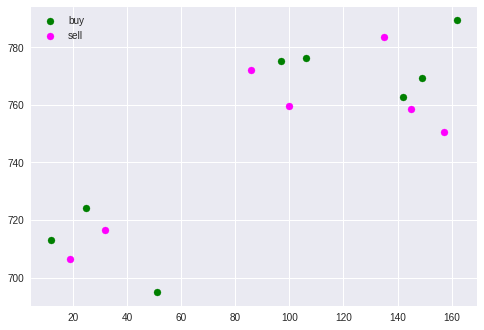

In [0]:
init_balance = 100000.0
balance = init_balance
cash_list= []
volume = 0
buyx = []
buyy =[]
selx = []
sely = []
for i in range(1,len(new_pred)): # from first prediction
    prediction= new_pred[i]
    if(prediction > new_pred[i-1] * 1.002 and volume == 0): #if current >previous 0.2% and have not buy
        volume = balance / newy_test[i] # buy with volume all balance/actual closing price
        buyx.append(i) # save buy record index
        buyy.append(newy_test[i])# save buy record price
        print( "Buy @" + str(newy_test[i])) # print buy volume

    if(volume > 0 and prediction * 1.002 < new_pred[i-1]): #check if have volume, and current < previous 0.2%
        balance = volume * newy_test[i] #sell all volume
        volume = 0
        selx.append(i) #save record
        sely.append(newy_test[i]) #save sell record
        print ("Sell @" + str(newy_test[i])) #print sell price
        print ("Balance: " + str(balance))# print balance

print ("Balance:" + str(balance)) #print final balance
print ("Yield:" + str((balance/init_balance-1)*100)+'%') #print final balance
plt2.scatter(buyx, buyy, color='green',label ='buy')
plt2.scatter(selx, sely, color='magenta', label ='sell')
plt2.legend()
plt2.grid(True)
plt2.show()

# Final prediction performance with simulate trading

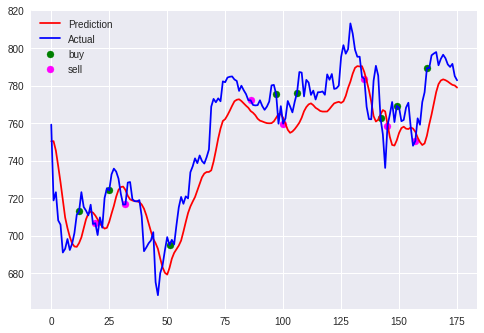

In [0]:
plt2.plot(new_pred,color='red', label='Prediction')
plt2.plot(newy_test,color='blue', label='Actual')
plt2.scatter(buyx, buyy, color='green',label='buy')
plt2.scatter(selx, sely, color='magenta',label='sell')
plt2.legend(loc='best')
plt2.show()